In [1]:
import os
import argparse
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from multissl.plotting.false_color import visualize_batch_semi, visualize_predictions

In [2]:
from multissl.models import SegmentationModel, DomainAdaptiveSegmentationModel, MeanTeacherSegmentation, GANMeanTeacher
from multissl.data import SegmentationDataset, SemiSupervisedSegmentationDataset, semi_supervised_collate_fn, get_transform

from multissl.data.seg_transforms import JointWeakAugmentation, JointStrongAugmentation

In [3]:
class UnfreezeBackboneCallback(pl.Callback):
    """
    Callback to unfreeze the last layer of the backbone after a specific number of epochs.
    """
    def __init__(self, unfreeze_epoch=50, verbose=True):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch
        self.verbose = verbose
        self.unfrozen = False
    
    def on_epoch_start(self, trainer, pl_module):
        # Check if we've reached the target epoch and haven't unfrozen yet
        if trainer.current_epoch == self.unfreeze_epoch and not self.unfrozen:
            # Handle both student-teacher and regular segmentation models
            if hasattr(pl_module, 'student'):
                # For student-teacher model, unfreeze last layer of student backbone
                self._unfreeze_last_layer(pl_module.student)
            else:
                # For regular segmentation model
                self._unfreeze_last_layer(pl_module)
            
            self.unfrozen = True
            if self.verbose:
                print(f"Unfrozen last layer of backbone at epoch {trainer.current_epoch}")
    
    def _unfreeze_last_layer(self, model):
        """Unfreeze the last layer of the backbone based on model type."""
        if hasattr(model, 'feature_extractor'):
            # Get the feature extractor
            feature_extractor = model.feature_extractor
            
            # Unfreeze based on backbone type
            if hasattr(feature_extractor, 'layer4'):
                # For ResNet models
                for param in feature_extractor.layer4.parameters():
                    param.requires_grad = True
            elif hasattr(feature_extractor, 'vit') and hasattr(feature_extractor.vit, 'blocks'):
                # For ViT models - unfreeze last transformer block
                last_block = feature_extractor.vit.blocks[-1]
                for param in last_block.parameters():
                    param.requires_grad = True
            elif hasattr(feature_extractor, 'swin') and hasattr(feature_extractor.swin, 'layers'):
                # For Swin models - unfreeze last stage
                last_stage = feature_extractor.swin.layers[-1]
                for param in last_stage.parameters():
                    param.requires_grad = True

In [4]:
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "unlabeled_dir": ["../dataset/vineseg/imgs/test_qbaixo","../dataset/vineseg/imgs/test_valdoeiro", "../dataset/vinseg/imgs/val_esac2"],  # Optional path or list of paths to unlabeled images
    "img_size": 224,
    "batch_size": 8,
    "num_workers": 8,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_r18/last.ckpt",
    "backbone_type": "resnet18",  # Options: resnet18, resnet50, vit-s, swin-tiny
    "num_classes": 2,
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 200,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "min_confidence_threshold" : 0.1,  # Starting threshold (lower)
    "max_confidence_threshold" : 0.9,  # Target threshold (higher)
    "consistency_weight": 1,
    "consistency_rampup": 10,  # Epochs for ramping up consistency weight
    "check_val_every_n_epoch": 5,  # Validate every N epochs
   
    # Domain adaptation parameters
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs (None to keep frozen)
    
    # Misc
    "seed": 42,
    "class_names": ["Background", "Vines"],  # Update with your class names
    "checkpoint_dir": "domain_adaptive_checkpoints",
    "project_name": "DomainAdaptiveSegmentation",
    "class_names": ["Background","Vines"],  # Update with your class names
    "class_weights": [1.0,1.0]
}

In [5]:
# Create train/val/test datasets
pl.seed_everything(CONFIG["seed"])
#Built around 2 different tf pipelines due to Mask-image and non-labeled samples
joint_tf = JointStrongAugmentation()
unlabeled_tf = get_transform(img_size= 224)


train_dataset = SemiSupervisedSegmentationDataset(
        img_dir=os.path.join(CONFIG["img_dir"], "train_all"),
        mask_dir=os.path.join(CONFIG["mask_dir"], "train_all"),
        unlabeled_dir=CONFIG["unlabeled_dir"],
        img_size=CONFIG["img_size"],
        joint_transform=joint_tf,
        unlabeled_transform=unlabeled_tf
    )
    

val_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "val_esac2"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "val_esac2"),
    img_size=CONFIG["img_size"]
)

test_dataset_v = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_valdoeiro"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_valdoeiro"),
    img_size=CONFIG["img_size"]
)

test_dataset_q = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_qbaixo"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_qbaixo"),
    img_size=CONFIG["img_size"]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    collate_fn = semi_supervised_collate_fn,
    persistent_workers = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,

)

test_loader_v = DataLoader(
    test_dataset_v,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,

)
test_loader_q = DataLoader(
    test_dataset_q,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,

)
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size valdoeiro: {len(test_dataset_v)}")
print(f"Test dataset size qbaixo: {len(test_dataset_q)}")

Seed set to 42


Dataset composition:
  - Labeled images: 96
  - Unlabeled images: 298
  - Total: 394
Train dataset size: 394
Validation dataset size: 97
Test dataset size valdoeiro: 157
Test dataset size qbaixo: 141


c:\users\judoj\documents\programming\multi_ssl\multissl\plotting\false_color.py:242: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


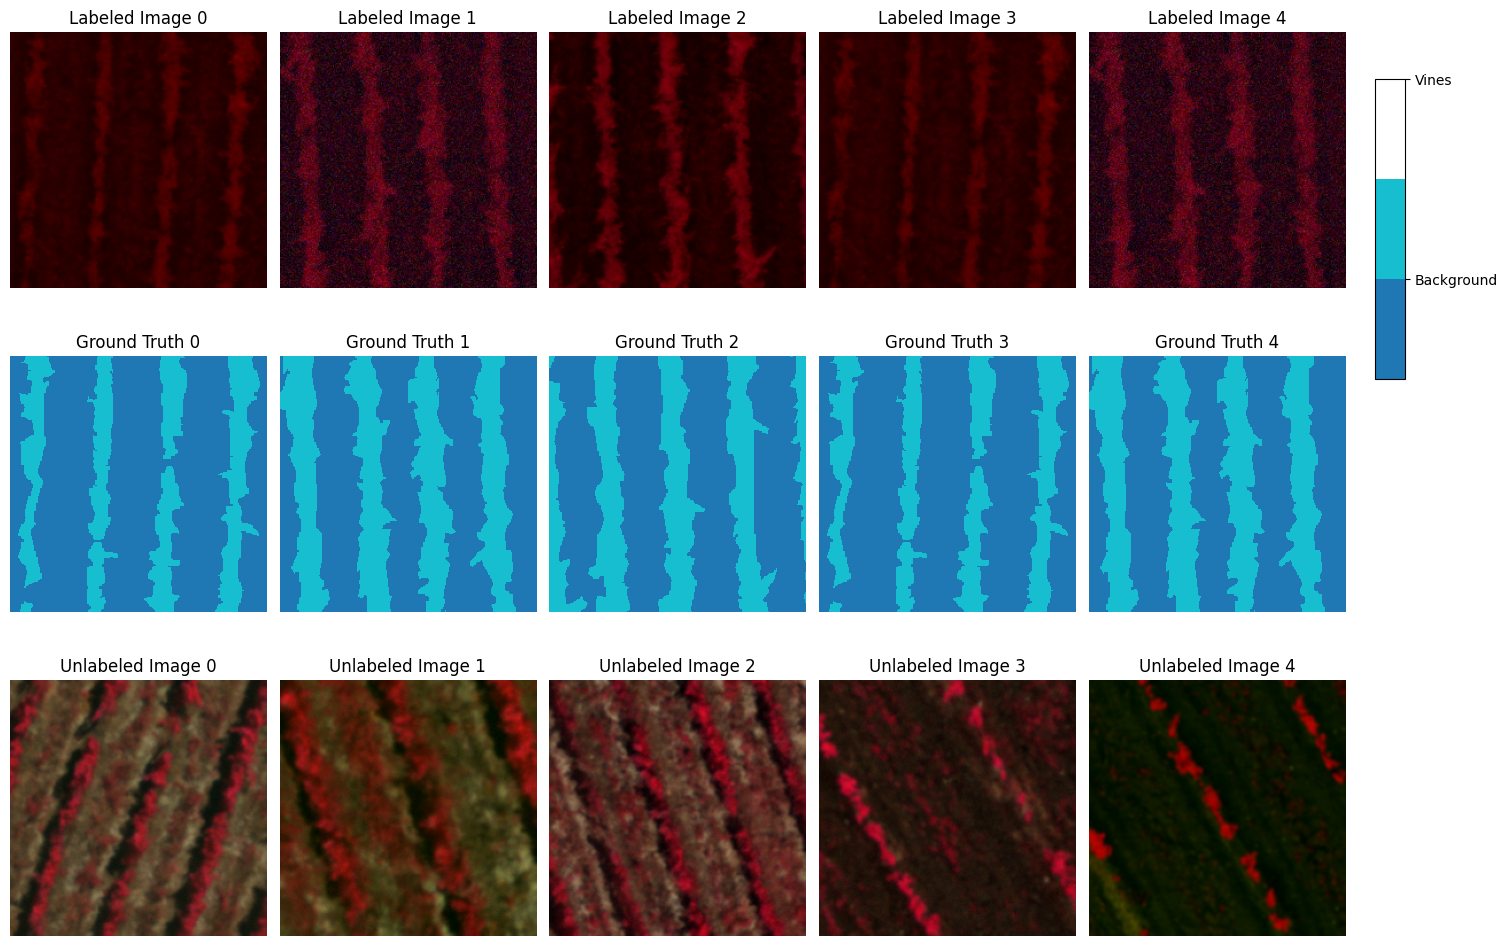

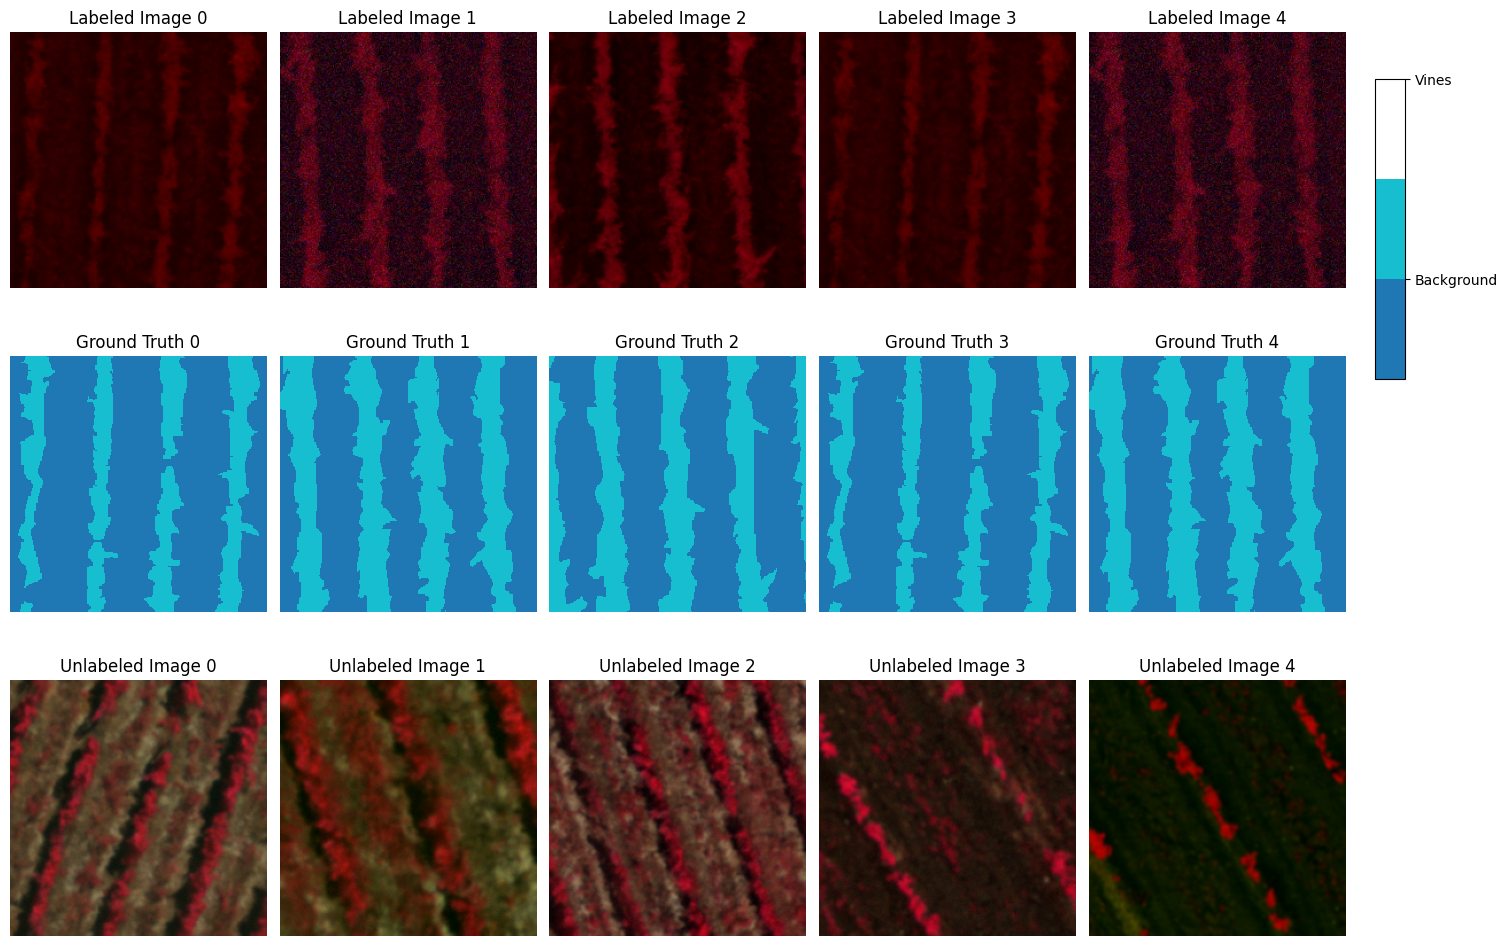

In [6]:
# Visualize a batch of training data
batch = next(iter(train_loader))
visualize_batch_semi(
    batch, 
    num_samples=8, 
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"] 
)

In [7]:
# For ResNet50 pretrained with FastSiam

model = GANMeanTeacher(
        backbone_type=CONFIG["backbone_type"],
        pretrained_path=CONFIG["pretrained_checkpoint"],
        in_channels=CONFIG["in_channels"],
        num_classes=CONFIG["num_classes"],
        img_size=CONFIG["img_size"],
        lr=CONFIG["lr"],
        consistency_rampup=CONFIG["consistency_rampup"],
        class_weights = CONFIG["class_weights"]
    )

Detected feature dimensions: layer1=64, layer2=128, layer3=256, layer4=512


In [8]:
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_callback = ModelCheckpoint(
    dirpath="segmentation_checkpoints",
    filename="ganmt_r18-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb

wandb_logger = WandbLogger(project="1SHOT_Segmentation", log_model=False)

unfreeze = UnfreezeBackboneCallback(unfreeze_epoch=CONFIG["unfreeze_backbone_after"])

# Create trainer
trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="cuda",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, RichProgressBar(), unfreeze],
    logger=wandb_logger,  # Comment out if not using wandb
    log_every_n_steps = 1,
    check_val_every_n_epoch=5,  # Only validate every 5 epochs
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
import time
import datetime

# Start the timer
start_time = time.time()


trainer.fit(model, train_loader, val_loader)
import wandb
wandb.finish()

# Calculate duration
end_time = time.time()
duration_seconds = end_time - start_time
duration_ms = duration_seconds * 1000

# Format as a readable duration
formatted_duration = str(datetime.timedelta(seconds=int(duration_seconds)))

# Print results
print(f"Training completed in: {formatted_duration} (H:M:S)")
print(f"Total seconds: {duration_seconds:.2f} s")
print(f"Total milliseconds: {duration_ms:.2f} ms")


wandb: Currently logged in as: jurriandoornbos (jurrain-phd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\optimizer.py:378: Found unsupported keys in the optimizer configuration: {'frequency'}


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ student      │ SegmentationModel      │ 15.1 M │ train │
│ 1 │ teacher      │ SegmentationModel      │ 15.1 M │ train │
│ 2 │ gen_u2l      │ StyleTransferGenerator │ 30.6 M │ train │
│ 3 │ disc_labeled │ StyleDiscriminator     │ 13.1 M │ train │
└───┴──────────────┴────────────────────────┴────────┴───────┘

Trainable params: 25.3 M                                                                                           
Non-trainable params: 48.7 M                                                                                       
Total params: 74.0 M                                                                                               
Total estimated model params size (MB): 295                                                                        
Modules in train mode: 489                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

In [ ]:
# Load the best model
device = "cuda"

best_model_path = checkpoint_callback.best_model_path
best_model = GANMeanTeacher.load_from_checkpoint(best_model_path, 
                                                    backbone_type = "resnet18")

best_model.eval()

print(f"Loaded best model from {best_model_path}")

uber_test_results_e2 = best_model.test(val_loader)

visualize_predictions(
    model=best_model,
    dataloader=val_loader,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_v = best_model.test(test_loader_v)


visualize_predictions(
    model=best_model,
    dataloader=test_loader_v,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_q = best_model.test(test_loader_q)

visualize_predictions(
    model=best_model,
    dataloader=test_loader_q,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [ ]:
from multissl.eval.eval import calculate_standard_error
e2 = calculate_standard_error(best_model, val_loader)

v = calculate_standard_error(best_model, test_loader_v)

q =calculate_standard_error(best_model, test_loader_q)


In [ ]:
# Save just the state dict for easier loading in production
model_state_dict_path = "vineseg_checkpoints/r18-bb-gan-meanteacher.pth"
torch.save(best_model.state_dict(), model_state_dict_path)
print(f"Saved model state dict to {model_state_dict_path}")